INFO:root: Models loaded
INFO:root: Models loaded
INFO:root: 2 faces detected
INFO:root: Saved progress images in folder: /home/fsuser/de-identification/dev-notebooks/server-test-3
INFO:root: ----- Face [1/2] ----- 


Starting losses:: Complete:0.3419, contextual:0.1648, perceptual:0.1772 (after x0.1)


INFO:root: ----- Face [2/2] ----- 


Final Losses (1000 iterations):: Complete:0.0316, contextual:0.0307, perceptual:0.0009 (after x0.1), time: 4.80s
Starting losses:: Complete:0.4324, contextual:0.1913, perceptual:0.2411 (after x0.1)
Final Losses (1000 iterations):: Complete:0.0412, contextual:0.0395, perceptual:0.0017 (after x0.1), time: 5.76s


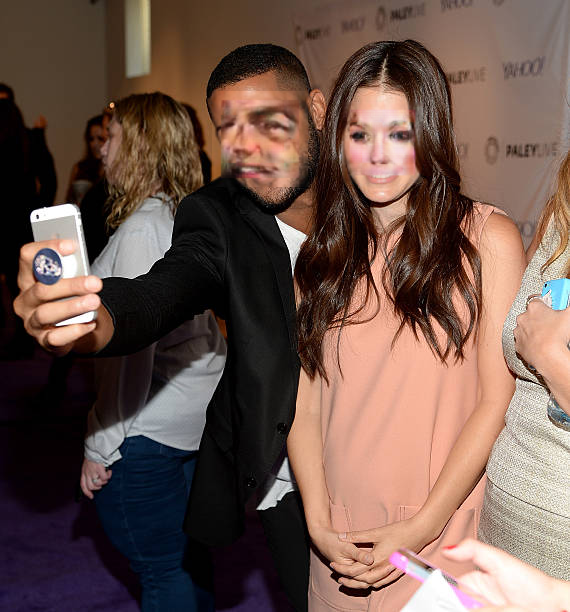

In [24]:
# pyright: reportUndefinedVariable=false

###### TO DO ######

# Add a lr scheduler and fine tune lr
# DO I detach the generator output from the graph?? i.e. which of the following 2 is right

# output = netD_loaded(generated.detach()).view(-1)
# output = netD_loaded(generated).view(-1)


import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
import os
import cv2
import time
import imageio
import logging
import argparse
import numpy as np
from PIL import Image, ImageDraw, ImageOps
from facenet_pytorch import MTCNN

logging.root.setLevel(logging.NOTSET)

#c:/Users/James/git/de-identification/
parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('--repo-dir', default="/home/fsuser/de-identification", help='Path to github repository')
parser.add_argument('--image-path', default="/home/fsuser/de-identification/dev-notebooks/media/facial-img-1.jpg", help='Path to github repository')
parser.add_argument('--save-folder', default="/home/fsuser/de-identification/dev-notebooks/server-test-3", help='Folder to save results in')
parser.add_argument('--border-factor', default=0.2, help='Width of border used for context in infilling GAN generation')
parser.add_argument('--progress-images', default=True, help='Save progress images & gif in folder')
parser.add_argument('--model-version', default='detection-10-epochs', help='Version of model to use')
parser.add_argument('--lr', default=0.0002, help='learning rate to use in training')
parser.add_argument('--lam', default=0.1, help='perceptual loss factor')
parser.add_argument('--iterations', default=5000, help='Number of iterations to train for')
parser.add_argument('--eval-interval', default=250, help='Number of iterations between evaluation')
parser.add_argument('--best-of-n', default=1, help='Number of best predictions to use for final prediction')
parser.add_argument('--poisson-blending', default=True, help='Use mask for context')

args = parser.parse_args("")

# assign args to variables. i.e now repo_dir == args.repo_dir
for arg in vars(args):
    exec(arg + '= args.' + arg)

if eval_interval == 0:
    eval_interval = iterations//10

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    logging.warning(" No GPU detected, using CPU instead.")


################# MODELS #################

# Generator Code

nz = 100 # Size of z latent vector (i.e. size of generator input)
nc = 3 # Number of channels in the training images. For color images this is 3
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


################# Load pretrained models #################

g_path = os.path.join(repo_dir, f"pretrained-models/DCGAN-{model_version}-netG.pth")
d_path = os.path.join(repo_dir, f"pretrained-models/DCGAN-{model_version}-netD.pth")

netG_loaded = Generator(ngpu).to(device)
netG_loaded.load_state_dict(torch.load(g_path, map_location=device))
netG_loaded.eval()

netD_loaded = Discriminator(ngpu).to(device)
netD_loaded.load_state_dict(torch.load(d_path, map_location=device))
netD_loaded.eval()

logging.info(" Models loaded")
logging.info(" Models loaded")

################# Helper and visualization functions #################

def generate_boxes(img, mtcnn, threshold = 0.7, min_size = 15):
    """Generates boxes for faces in image using MTCNN
    Parameters:
        img: image to detect faces in
        threshold: minimum probability for face detection
        min_size: minimum size of face to detect
    
    """
    all_boxes, probs, _ = mtcnn.detect(img.copy(), landmarks=True)
    if all_boxes is None:
        return []
    #'max' needed as MTCNN gives box values outside of image, e.g. [-6, 135, 69, 229],
    all_boxes = [[max(int(x), 0) for x in box] for box in all_boxes] 
    boxes = []
    for box, prob in zip(all_boxes, probs):
        width = box[2] - box[0]
        height = box[3] - box[1]
        if prob >= threshold and width > min_size and height > min_size:
            boxes.append(box)
    return boxes

def crop_face(face, x, y):
    """Turns image into a square by cropping
    Parameters:
        face: image to crop
        x, y: coordinates of top left corner of face
    
    Returns:
        face: cropped image
        x, y: adjusted x, y coordinates of where cropped face starts
    """
    height, width, _ = face.shape
    if height > width:
        diff = height - width
        top_crop = diff // 2
        bottom_crop = diff - top_crop
        face = face[top_crop:-bottom_crop, :]
        y+=top_crop
    elif width > height:
        diff = width - height
        left_crop = diff // 2
        right_crop = diff - left_crop
        face = face[:, left_crop:-right_crop]
        x+=left_crop

    assert face.shape[0] == face.shape[1], "Face is not square"
    return face, x, y

def draw_boxes(img, boxes, masks=None):
    """Overlays boxes on image (& masks if provided)
    Parameters:
        img: image to draw boxes on
        boxes: list of boxes to draw, 
            ones in format (x1, y1, x2, y2) will display red
            ones in format (x1, y1, x2, y2, colour) will display colour
        masks: list of mask areas to remove from image

    Returns:
        frame_draw: image with boxes drawn on
    
    """""
    frame_draw = img.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        colour = (255, 0, 0) if len(box) == 4 else box[4]
        draw.rectangle(box[:4], outline=colour, width=3) # box = (x1, y1, x2, y2, colour)
    if masks is not None:
        for mask in masks:
            draw.rectangle(mask[:4], fill=(255,255,255))
    return frame_draw

def visualize_boxes(boxes, np_img, display_inline = False, save = True):
    """ Visualizing boxes, squares and masks on image
    Parameters:
        boxes: list of boxes
        square_faces: list of square faces, each in format (face, x, y)
        display_inline: display images inline in notebook

    Saves:
        1-original.jpg: original image
        2-boxes.jpg: original image with boxes drawn
        3-boxes_squares.jpg: original image with boxes & squares drawn
        4-boxes_squares_masks.jpg: original image with boxes, squares & masks drawn
    """
    
    square_faces = [] # [[square_face, x, y], ...]
    for (x1, y1, x2, y2) in boxes:
        square_face, x, y = crop_face(np_img[y1:y2, x1:x2], x1, y1)
        square_faces.append([square_face, x, y])

    squares = []
    masks = []
    for (square_face, x, y) in square_faces:
        square_size = square_face.shape[0]
        squares.append([x, y, x+square_size, y+square_size, (0, 255, 0)])
        square_border = int(square_size * border_factor)
        #-1 is important for visualization alignment, draw.rectangle is inclusive so adds 1 extra
        masks.append([x+square_border, y+square_border, x+square_size-square_border-1, y+square_size-square_border-1])

    img = Image.fromarray(np_img)
    images = [img, draw_boxes(img, boxes), draw_boxes(img, boxes + squares), draw_boxes(img, boxes + squares, masks), draw_boxes(img, squares)]
    save_filenames = ["1-original.jpg", "2-boxes.jpg", "3-boxes_squares.jpg", "4-boxes_squares_masks.jpg", "5-squares.jpg"]
    
    for image, filename in zip(images[:-1], save_filenames[:-1]):
        if save:
            image.save(os.path.join(save_folder, filename))
        if display_inline:
            display(image)

    if save:
        logging.info(f" Saved progress images in folder: {save_folder}")
    return images

def best_generated(zhats, transformed_face, mask):
    """ Finds the best of n generated images
    
    Parameters:
    zhats: latent vector tensor of shape (best_of_n, nz, 1, 1)
    transformed_face: tensor of shape (3, H, W)
    mask: tensor of shape (1, 3, H, W)
    
    Returns:
    index of best generated image
    """
    zhats, transformed_face, mask = zhats.to(device), transformed_face.to(device), mask.to(device)

    with torch.no_grad():
        generated = netG_loaded(zhats)

    best_loss = float("inf")
    best_generated = None

    perceptual_criteron = nn.BCELoss()
    for i in range(best_of_n):
        gen = generated[i]
        contextual_loss = nn.functional.l1_loss(mask[0]*gen, mask[0]*transformed_face) # keep outside obscured region the same

        real_label = torch.full((1,), 1., dtype=torch.float, device=device)
        output = netD_loaded(gen.unsqueeze(dim=0)).view(-1)
        perceptual_loss = perceptual_criteron(output.detach(), real_label) #g_loss
        complete_loss = contextual_loss + lam*perceptual_loss
        if complete_loss.item() < best_loss:
            best_loss = complete_loss.item()
            best_generated = i

    return best_generated

def generated_combined_img(generated_face, square_face):
    """Generates a combined image of the generated face and the original image
    Parameters:
        generated_face: normalized tensor of shape (3, img_size, img_size)
        square_face: numpy array of shape (H, W, 3)

    Returns:
        combined_img: numpy array of shape (H, W, 3)
    """
    target_size = square_face.shape[0]
    border_width = int(target_size * border_factor)

    # Resize generated face to target size
    resize_transform = transforms.Resize(target_size, antialias = False)
    generated_face = resize_transform(generated_face)

    #Convert generated face to PIL format
    generated_face = vutils.make_grid(generated_face, padding=2, normalize=True).permute(1, 2, 0)
    generated_face = (generated_face.numpy() * 255).astype(np.uint8) #64x64x3
    Image.fromarray(generated_face)

    # Use Poisson blending to combine generated face with original image
    border_width = int(target_size * border_factor)
    src_mask = np.zeros(square_face.shape, square_face.dtype)
    square = np.array([[border_width,border_width], [target_size-border_width,border_width], [target_size-border_width,target_size-border_width], [border_width, target_size-border_width]], np.int32)
    cv2.fillPoly(src_mask, [square], (255, 255, 255))
    center = (target_size//2,target_size//2)
    combined = cv2.seamlessClone(generated_face[:, :, ::-1], square_face[:, :, ::-1], src_mask, center, cv2.NORMAL_CLONE)[:, :, ::-1]

    return combined

################# Training  #################

#### Hyperparameters ###
def inpaint_face(real_face, border_factor = 0.1):
    real_face = real_face.unsqueeze(dim=0)

    lr = 0.3
    iterations = 1000
    eval_interval = 250
    lam = 0.1 # perceptual_loss factor

    border_width = int(64 * border_factor)
    mask = torch.ones(1, 3, 64, 64)
    mask[:, :, border_width:-border_width, border_width:-border_width] = 0

    fixed_noise = torch.randn(1, nz, 1, 1, device=device).requires_grad_(True)
    fixed_noise, real_face, mask = fixed_noise.to(device), real_face.to(device), mask.to(device)

    with torch.no_grad():
        fake_faces = netG_loaded(fixed_noise)

    results=[fake_faces.clone()]

    criterion = nn.BCELoss()
    optimizer = optim.Adam([fixed_noise], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

    t_start = time.time()
    for i in range(iterations):
        fake_faces = netG_loaded(fixed_noise)
        contextual_loss = nn.functional.l1_loss(mask*fake_faces, mask*real_face)


        real_label = torch.ones(1).to(device)
        d_output = netD_loaded(fake_faces).view(-1) # detach??
        perceptual_loss = criterion(d_output, real_label) #g_loss

        complete_loss = contextual_loss + lam*perceptual_loss
        if i == 0:
            print("Starting losses:: Complete:{:.4f}, contextual:{:.4f}, perceptual:{:.4f} (after x0.1)".format(complete_loss, contextual_loss, lam*perceptual_loss))

        optimizer.zero_grad()
        complete_loss.backward()
        optimizer.step()
        scheduler.step()

        if i % eval_interval == eval_interval-1:
            # print(f"i: {i} Losses:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")
            results.append(fake_faces.clone())

    print(f"Final Losses ({i+1} iterations):: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")
    results.append(real_face.clone())
    results_returned = []
    for r in results:
        combined_faces = real_face*mask + fake_faces*(1-mask)
        results_returned.append(combined_faces.detach().cpu()[0])
    
    return results_returned

image_size = 64 # to change this GAN has to be retrained first

img_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

################# Loading image #################

mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model

img = Image.open(image_path)
boxes = generate_boxes(img, mtcnn)
# Ordering boxes/faces largest to smallest
boxes.sort(key=lambda x: (x[2]-x[0])*(x[3]-x[1]), reverse=True)
logging.info(f" {len(boxes)} faces detected")

full_process_gif = visualize_boxes(boxes, np.array(img), display_inline=False, save = progress_images)[:2]

square_faces = [] # [[square_face, x, y], ...]

np_img = np.array(img)

for i, (x1, y1, x2, y2) in enumerate(boxes):
    logging.info(f" ----- Face [{i+1}/{len(boxes)}] ----- ")
    square_face, x, y = crop_face(np_img[y1:y2, x1:x2], x1, y1)
    transformed_face = img_transforms(Image.fromarray(square_face))
    results = inpaint_face(transformed_face)

    target_size = square_face.shape[0]
    resize_transform = transforms.Resize(target_size, antialias = False)
    generated_face = resize_transform(results[-1])
    display_img = (vutils.make_grid(generated_face, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8)

    ##Visualization (for gif ONLY)
    # for prog in progress:
        # border_width = int(target_size * border_factor)
    #     np_img_gif = np.copy(np_img)
    #     full_process_gif.extend(visualize_boxes([[x1, y1, x2, y2]], np_img_gif, save = False)[1:-1])
    #     combined_img = generated_combined_img(prog[best_generated_index].clone().cpu(), np.copy(square_face))
    #     np_img_gif[y+border_width:y+target_size-border_width, x+border_width:x+target_size-border_width] = combined_img[border_width:-border_width, border_width:-border_width]
    #     # full_process_gif.append(Image.fromarray(np.copy(np_img_gif)))
    #     # display(Image.fromarray(np.copy(np_img_gif)))
    #     full_process_gif.append(visualize_boxes([[x1, y1, x2, y2]], np.copy(np_img_gif), save = False)[4])    

    # Paste generated face inside border back into original image 
    np_img[y:y+target_size, x:x+target_size] = display_img
    
final_img = Image.fromarray(np_img)

display(final_img)

In [14]:
full_process_gif.append(Image.fromarray(np.copy(np_img)))
gif_path = os.path.join(save_folder, f"full_process.gif")
imageio.mimsave(gif_path, full_process_gif, duration=1)
logging.info(f" Saved full process gif: {gif_path}")

final_img_filepath = os.path.join(save_folder, f"final.png")
final_img.save(final_img_filepath)
logging.info(f" Saved final image: {final_img_filepath}")
final_img

Starting losses:: Complete:0.2169, contextual:0.1425, perceptual:0.0744 (after x0.1)
Final Losses (1000 iterations):: Complete:0.0370, contextual:0.0368, perceptual:0.0003 (after x0.1), time: 4.54s


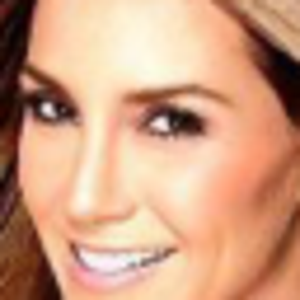

In [18]:
display_img = Image.fromarray((vutils.make_grid(transformed_face, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (300, 300)))

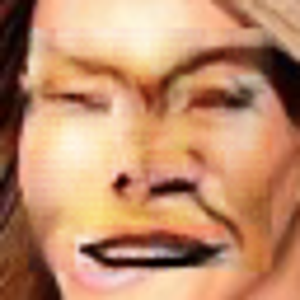

In [17]:
display_img = Image.fromarray((vutils.make_grid(results[-1], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (300, 300)))